In [1]:
import fairlib
import torch
import numpy as np

In [2]:
default_args = {
    "results_dir" : r"..\Results",
    "project_dir" : "Bios_both",
    "checkpoint_dir": "models",
    "checkpoint_name": "checkpoint_epoch",
}

In [3]:
from fairlib.src.analysis.utils import get_dir

exp_dirs = get_dir(
    results_dir=default_args["results_dir"], 
    project_dir=default_args["project_dir"],
    checkpoint_dir=default_args["checkpoint_dir"],
    checkpoint_name=default_args["checkpoint_name"],
    model_id = "test",
    )

In [4]:
exp_dirs[0]["dir"][:5]

['..\\Results\\Bios_both\\test\\models\\checkpoint_epoch0.00.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch0.70.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch1.00.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch1.70.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch10.00.pth.tar']

In [5]:
professions = ["accountant", "architect", "attorney", "chiropractor", "comedian", "composer", "dentist", "dietitian", "dj", "filmmaker", "interior_designer", "journalist", "model", "nurse", "painter", "paralegal", "pastor", "personal_trainer", "photographer", "physician", "poet", "professor", "psychologist", "rapper", "software_engineer", "surgeon", "teacher", "yoga_teacher"]

In [6]:
# Load epoch results
epoch_results = {}
for _k in exp_dirs[0]["dir"]:
    epoch_results[_k.split("checkpoint_epoch")[1][:-8]] = torch.load(_k)

In [7]:
print(epoch_results["9.00"].keys())

dict_keys(['epoch', 'epochs_since_improvement', 'loss', 'valid_confusion_matrices', 'test_confusion_matrices', 'dev_evaluations', 'test_evaluations', 'dev_predictions', 'test_predictions'])


In [8]:
from fairlib.src.evaluators.evaluator import confusion_matrix_based_scores

In [9]:
distinct_groups = [0,1,2,3]

print(epoch_results["9.00"]["valid_confusion_matrices"].keys())

dict_keys(['overall', 0, 1, 2, 3])


In [10]:
epoch_tprs = {}
for epoch_id in epoch_results.keys():
    tprs = []
    for g_id in distinct_groups:
        g_tpr = confusion_matrix_based_scores(epoch_results[epoch_id]["valid_confusion_matrices"][g_id])["TPR"]
        tprs.append(g_tpr)
    epoch_tprs[epoch_id] = np.stack(tprs)

In [11]:
# num of groups * num of classes
epoch_tprs["9.00"].shape

(4, 28)

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

[Text(0.5, 0, 'accountant'),
 Text(1.5, 0, 'architect'),
 Text(2.5, 0, 'attorney'),
 Text(3.5, 0, 'chiropractor'),
 Text(4.5, 0, 'comedian'),
 Text(5.5, 0, 'composer'),
 Text(6.5, 0, 'dentist'),
 Text(7.5, 0, 'dietitian'),
 Text(8.5, 0, 'dj'),
 Text(9.5, 0, 'filmmaker'),
 Text(10.5, 0, 'interior_designer'),
 Text(11.5, 0, 'journalist'),
 Text(12.5, 0, 'model'),
 Text(13.5, 0, 'nurse'),
 Text(14.5, 0, 'painter'),
 Text(15.5, 0, 'paralegal'),
 Text(16.5, 0, 'pastor'),
 Text(17.5, 0, 'personal_trainer'),
 Text(18.5, 0, 'photographer'),
 Text(19.5, 0, 'physician'),
 Text(20.5, 0, 'poet'),
 Text(21.5, 0, 'professor'),
 Text(22.5, 0, 'psychologist'),
 Text(23.5, 0, 'rapper'),
 Text(24.5, 0, 'software_engineer'),
 Text(25.5, 0, 'surgeon'),
 Text(26.5, 0, 'teacher'),
 Text(27.5, 0, 'yoga_teacher')]

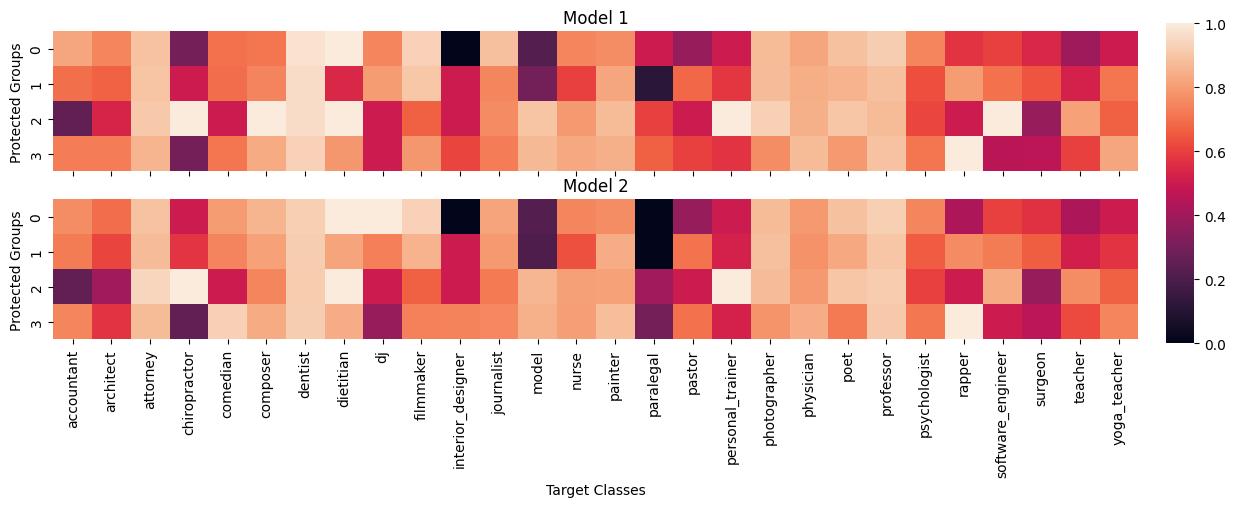

In [13]:
f, (a0, a1) = plt.subplots(2, 1, figsize=(14, 4), sharex=True)

cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])

sns.heatmap(epoch_tprs["9.00"], ax=a0, vmin=0, vmax=1, cbar=False)
sns.heatmap(epoch_tprs["5.00"], ax=a1, vmin=0, vmax=1, cbar_ax=cbar_ax)

a1.set_xlabel("Target Classes")
a0.set_ylabel("Protected Groups")
a1.set_ylabel("Protected Groups")

a0.set_title("Model 1")
a1.set_title("Model 2")

a1.set_xticklabels(professions, rotation=90)

# f.savefig("tpr_row_metrics_h.pdf", format="pdf", dpi=960, bbox_inches="tight") 

In [14]:
print(epoch_results["9.00"]["valid_confusion_matrices"].keys())

dict_keys(['overall', 0, 1, 2, 3])


In [15]:
example_cnfs = epoch_results["9.00"]["valid_confusion_matrices"]

In [16]:
example_all_scores = {}
example_all_scores["overall"] = confusion_matrix_based_scores(example_cnfs["overall"])
for gid in range(4):
    example_all_scores[gid] = confusion_matrix_based_scores(example_cnfs[gid])

In [17]:
example_metric_name = "TPR"

In [18]:
example_all_scores["overall"][example_metric_name]

array([0.7103448 , 0.68438537, 0.88364054, 0.4404762 , 0.6941176 ,
       0.75886521, 0.95225462, 0.79389308, 0.73809512, 0.85849053,
       0.56521736, 0.75127767, 0.75576035, 0.80905511, 0.82894734,
       0.54347824, 0.62499996, 0.57777774, 0.84698608, 0.85307212,
       0.83428568, 0.89058679, 0.67460317, 0.76470573, 0.66666665,
       0.60051546, 0.58035714, 0.77499986])

### Basic Unit

In [19]:
def basic_unit_scores(distinct_groups, all_scores, metric):
    group_scores = []
    for gid in distinct_groups:
        # Save the TPR direct to the list 
        group_scores.append(all_scores[gid][metric]) 
    # n_class * n_groups
    scores = np.stack(group_scores, axis = 1)    
    return scores

In [20]:
def basic_unit_gap(distinct_groups, all_scores, metric):
    # n_class * n_groups
    Scores = basic_unit_scores(distinct_groups, all_scores, metric)
    # Calculate GAP (n_class * n_groups) - (n_class * 1)
    score_gaps = Scores - all_scores["overall"][metric].reshape(-1,1)
    return score_gaps

In [21]:
def basic_unit_ratios(distinct_groups, all_scores, metric):
    # n_class * n_groups
    Scores = basic_unit_scores(distinct_groups, all_scores, metric)
    # Calculate Ratios (n_class * n_groups) - (n_class * 1)
    score_ratios = Scores / all_scores["overall"][metric].reshape(-1,1)
    return score_ratios

[Text(0.5, 0, 'accountant'),
 Text(1.5, 0, 'architect'),
 Text(2.5, 0, 'attorney'),
 Text(3.5, 0, 'chiropractor'),
 Text(4.5, 0, 'comedian'),
 Text(5.5, 0, 'composer'),
 Text(6.5, 0, 'dentist'),
 Text(7.5, 0, 'dietitian'),
 Text(8.5, 0, 'dj'),
 Text(9.5, 0, 'filmmaker'),
 Text(10.5, 0, 'interior_designer'),
 Text(11.5, 0, 'journalist'),
 Text(12.5, 0, 'model'),
 Text(13.5, 0, 'nurse'),
 Text(14.5, 0, 'painter'),
 Text(15.5, 0, 'paralegal'),
 Text(16.5, 0, 'pastor'),
 Text(17.5, 0, 'personal_trainer'),
 Text(18.5, 0, 'photographer'),
 Text(19.5, 0, 'physician'),
 Text(20.5, 0, 'poet'),
 Text(21.5, 0, 'professor'),
 Text(22.5, 0, 'psychologist'),
 Text(23.5, 0, 'rapper'),
 Text(24.5, 0, 'software_engineer'),
 Text(25.5, 0, 'surgeon'),
 Text(26.5, 0, 'teacher'),
 Text(27.5, 0, 'yoga_teacher')]

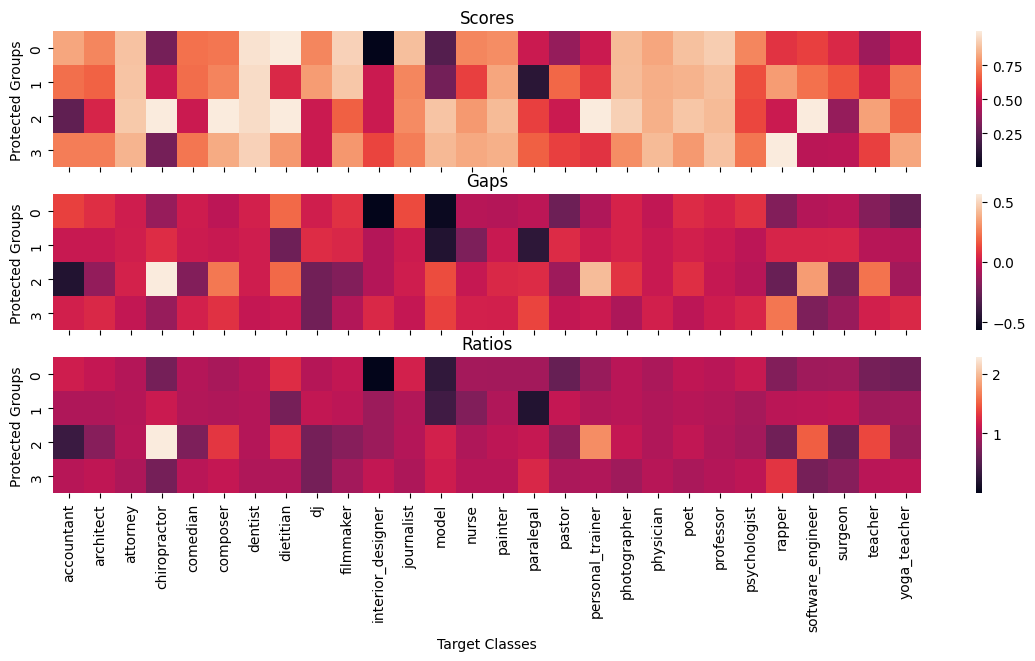

In [22]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

example_scores = basic_unit_scores(distinct_groups = [i for i in range(4)], all_scores = example_all_scores, metric = example_metric_name)

example_gaps = basic_unit_gap(distinct_groups = [i for i in range(4)], all_scores = example_all_scores, metric = example_metric_name)

example_ratios = basic_unit_ratios(distinct_groups = [i for i in range(4)], all_scores = example_all_scores, metric = example_metric_name)


sns.heatmap(example_scores.T, cbar=True, ax=ax0)

sns.heatmap(example_gaps.T, cbar=True, ax=ax1)

sns.heatmap(example_ratios.T, cbar=True, ax=ax2)

ax2.set_xlabel("Target Classes")
ax0.set_ylabel("Protected Groups")
ax1.set_ylabel("Protected Groups")
ax2.set_ylabel("Protected Groups")

ax0.set_title("Scores")
ax1.set_title("Gaps")
ax2.set_title("Ratios")

ax2.set_xticklabels(professions, rotation=90)

In [23]:
from fairlib.src.evaluators.evaluator import power_mean

In [24]:
def generalized_mean_aggregation(basic_units, group_power, class_power):
    results_per_class =power_mean(basic_units,p=group_power,axis=1)
    aggregated_results = power_mean(results_per_class, class_power)
    return aggregated_results

In [25]:
generalized_mean_aggregation(example_scores, 2, 2)

0.734121477613391

In [26]:
generalized_mean_aggregation(example_gaps, 2, 2)

0.1653569003196824

In [27]:
generalized_mean_aggregation(example_ratios, 2, 2)

0.9990359428738906